# Анализ моделей Heteromyopia

Классическая модель Heteromyopia. Реализация по статье Murrell David J., Law Richard. Heteromyopia and the spatial coexistence of similar competitors \// Ecology Letters. 2003. Т.6, №1. c. 48–59. URL: http://dx.doi.org/10.1046/j.1461-0248.2003.00397.x.

Heteromyopia - это механизм, при котором особи внутри вида конкурируют на большем расстоянии, чем особи разных видов. Мы реализуем этот эффект путем изменения дисперсии ядер межвидовой конкуренции $\sigma_{12}^w$, $\sigma_{21}^w$ и внутривидовой конкуренции $\sigma_{11}^w$, $\sigma_{22}^w$.

В рассматриваемой модели Heteromyopia, согласно статье (Figure 2), устанавливается следующее соотношение параметров:

$$\sigma_{11}^w = \sigma_{22}^w; \quad \sigma_{12}^w = \sigma_{21}^w$$


### Симметричная динамика видов

Так как мы выбираем симметричные параметры, то в одинаковых начальных условиях вид 1 и вид 2 не будут иметь преимущество между друг другом. Поэтому умереть может любой вид.

### Случай вымирания одного вида

Для этого возьмем параметры $\sigma_{ii}^w = 0.03$ и $\sigma_{ij}^w = 0.06$. То есть радиус внутривидового конкурентного влияния меньше, чем радиус межвидового конкурентного влияния. Значит один вид вымирает, потому что каждый вид создаёт более благоприятные условия для себя, чем для конкурента, что запускает самоусиливающийся процесс доминирования.

Когда вид слабо конкурирует внутри себя, но сильно подавляет другой вид, любое случайное преимущество усиливается с течением времени. А вид, получивший численное преимущество, продолжает увеличивать численность, одновременно всё сильнее подавляя конкурента.

### Случай сосуществования видов

Попробуем взять параметры $\sigma_{ii}^w = 0.06$ и $\sigma_{ij}^w = 0.03$. Здесь уже радиус внутривидовой конкуренции больше, чем межвидовой. В таком случае оба вида будут сосуществовать, потому что каждый вид создаёт более благоприятные условия для своего конкурента, чем для себя. Это формирует механизм отрицательной обратной связи, стабилизирующий сосуществование: когда численность вида возрастает, он в первую очередь подавляет сам себя.

Как только один вид начинает доминировать, он начинает угнетать сам себя, что позволяет другому виду размножиться, и так происходит бесконечный цикл. При этом особи каждого вида стремятся находиться на большем расстоянии друг от друга, чем от особей другого вида.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import sys
import os
from tqdm import tqdm
from scipy.stats import rayleigh
from matplotlib import animation
from matplotlib.animation import FuncAnimation

Смотрим на то, где находится корень проекта.

In [2]:
os.getcwd()

'/home/michael/SBDPP_sim/examples'

Указываем корень проекта.

In [3]:
sys.path.append("/home/michael/SBDPP_sim") # ваш путь к папке с проектом
import simulation

In [4]:
M = 2          # Количество видов
my_seed = 42   # seed для генератора случайных чисел

Генерируем палитру с фиксированными цветами для M видов и создаем словарь: {вид: цвет}

In [5]:
colors = sns.color_palette("tab10", M)
color_dict = {i: colors[i] for i in range(M)}

Инициализируем все параметры и устанавливаем виды в начальные позиции.

In [6]:
L = 2.0                           # Размер области

birth_rates = [0.4, 0.4]          # Вероятность рождаемости
natural_death_rates = [0.2, 0.2]  # Вероятность естественной смерти
competition_matrix = [            # Матрица конкуренции
    0.001, 0.001,                 # Влияние вида 1 на вид 1 и на вид 2
    0.001, 0.001                  # Влияние вида 2 на вид 1 и на вид 2
]                               

sigma_m = [0.04, 0.04]            # Радиус распространения потомства

#  Для сосущестования двух видов
sigma_w = np.array([              # Радиус влияния конкуренции
    [0.06, 0.03],
    [0.03, 0.06],
])

# Для вымирания одного вида (раскоментрировать)
# sigma_w = np.array([
#     [0.03, 0.06],
#     [0.06, 0.03],
# ])

def normal_2d_radial(r, sigma):
    return (1 / (2 * np.pi * sigma**2)) * np.exp(-r**2 / (2 * sigma**2))


q_values = np.arange(0, 1.0, 0.001)

birth_inverse_values = []
for i in range(M):
    inverse_vals = rayleigh.ppf(q_values, scale=sigma_m[i])
    birth_inverse_values.append(inverse_vals.tolist())

death_r_values = []
death_density_values = []

for i in range(M):
    r_values_row = []
    density_row = []
    
    for j in range(M):
        r_max = min(10 * sigma_w[i,j], L/2)
        r_vals = np.linspace(0, r_max, 500)
        
        density = normal_2d_radial(r_vals, sigma_w[i, j])
        
        r_values_row.append(r_vals.tolist())
        density_row.append(density.tolist())
    
    death_r_values.append(r_values_row)
    death_density_values.append(density_row)


max_sigma = max(max(sigma_m), np.max(sigma_w))
max_r = min(10 * max_sigma, L/2)

g2 = simulation.PyGrid2(
    M = M,
    areaLen = [L, L],
    cellCount = [50, 50],
    isPeriodic = False,
    birthRates = birth_rates,
    deathRates = natural_death_rates,
    ddMatrix = competition_matrix,
    birthX = [q_values.tolist()] * M,
    birthY = birth_inverse_values,
    deathX_ = death_r_values,
    deathY_ = death_density_values,
    cutoffs = [max_r] * (M * M),
    seed = my_seed,
    rtimeLimit = 7200.0
)

np.random.seed(my_seed)
coordinates = []
for _ in range(M):
    group = [[np.random.uniform(0, L), np.random.uniform(0, L)] for _ in range(500)]
    coordinates.append(group)

g2.placePopulation(coordinates)

Производим симуляцию.

In [7]:
data = []
for t in (pbar := tqdm(range(2000))):
    for c in range(g2.get_num_cells()):
        for n in range(M):
            coords = g2.get_cell_coords(c, n)
            for x, y in coords:
                data.append([t, x, y, n])
    g2.run_for(1)
    pbar.set_description(f"Population: {g2.total_population}, Progress")

df = pd.DataFrame(columns = ['time', 'x', 'y', 's'], data = data)
# display(df.set_index('time'))

Population: 691, Progress: 100%|██████████| 2000/2000 [00:29<00:00, 68.83it/s]


Выводим график первых моментов.

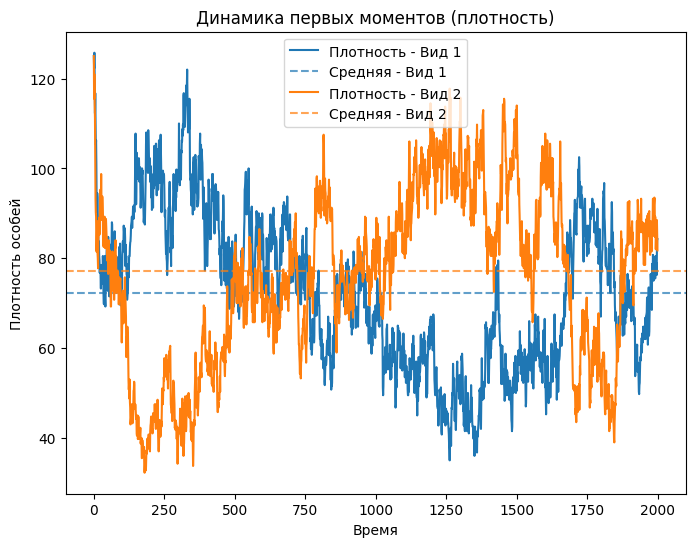

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))

for n in range(M):
    density = df[df['s'] == n].groupby('time').size() / (L ** 2)  
    median_density = density.median()

    ax.plot(density.index, density.values, label=f'Плотность - Вид {n+1}', color=color_dict[n])
    ax.axhline(median_density, linestyle="dashed", color=color_dict[n], alpha=0.7, label=f'Средняя - Вид {n+1}')

ax.legend()
ax.set_xlabel("Время")
ax.set_ylabel("Плотность особей")
ax.set_title("Динамика первых моментов (плотность)")

plt.show()

По полученным данным создаем видео.

In [ ]:
total_frames = df['time'].nunique()
desired_duration = 120
fps = total_frames / desired_duration

movie_writer = animation.FFMpegWriter(
    fps = fps,
    codec = 'h264',
    bitrate = 2000,
    extra_args = [
        '-vcodec', 'libx264',
        '-pix_fmt', 'yuv420p',
        '-preset', 'medium'
    ]
)

matplotlib.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # путь к ffmpeg

df = df.sort_values('time')
output_file = "Heteromyopia_1min.mp4"

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_xlabel('x')
ax.set_ylabel('y')
sc = ax.scatter([], [], c=[], s=20, alpha=0.6)

def update(frame):
    current_df = df[df['time'] == frame]
    sc.set_offsets(current_df[['x', 'y']].values)
    sc.set_color([color_dict[s] for s in current_df['s']])
    ax.set_title(f"Time: {frame}")
    return sc,

ani = FuncAnimation(fig, update, frames=df['time'].nunique(), blit=True)
progress_callback = tqdm(total=total_frames, desc='Creating 1-minute video')

def on_frame(current_frame, *args):
    progress_callback.update(1)

ani.save(output_file, writer=movie_writer, progress_callback=on_frame)
progress_callback.close()

print(f"Animation saved as {output_file} (duration: 1 minute)")
plt.close(fig)